In [25]:
%%HTML
<style type="text/css">
    table.dataframe td, table.dataframe th {
        border: 1px solid #B6B6B6;
        text-align: center !important;
    }
    th {
        background-color: #ADD8E6;
    }
    
</style>

# Library and Load Data

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy

from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

In [27]:
def check_information(df):
    # show dataframe for each features that we have
    dataFeatures = []
    dataType     = []
    null         = []
    nullPCT      = []
    unique       = []
    minValue     = []
    maxValue     = []
    uniqueSample = []


    for item in list(df):
        dataFeatures.append(item)

    for item in dataFeatures:
        dataType.append(df[item].dtype.name)

    for item in dataFeatures:
        null.append(len(df[df[item].isnull() == True]))

    for item in dataFeatures:
        nullPCT.append(round(len(df[df[item].isnull() == True])/len(df[item])*100,2))

    for item in dataFeatures:
        minValue.append(df[item].min())

    for item in dataFeatures:
        maxValue.append(df[item].max())

    for item in dataFeatures:
        unique.append(df[item].nunique())

    for item in dataFeatures:
        uniqueSample.append(df[item].unique()[0:2])

    df_info = pd.DataFrame({
        'dataFeatures' : dataFeatures,
        'dataType' : dataType,
        'null' : null,
        'nullPCT':nullPCT,
        'unique' : unique,
        'minValue' : minValue,
        'maxValue' : maxValue,
        'uniqueSample':uniqueSample
    })
    return df_info

In [28]:
# ---- set database connection
database_username = 'root'
database_password = 'balab'
database_ip       = '172.17.0.5'
database_name     = 'data_hackathon'
database_connection = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                               format(database_username, database_password,
                                                      database_ip, database_name))
data = pd.read_sql('select * from data_source',con=database_connection)
data.head()

,TIME_STAMP,ROLL,PITCH,SPEED_VG,SPEED_LG,SPEED_TG,SPEED_LW,REL_WIND_SPEED,REL_WIND_DIR,COURSE_OVER_GROUND,...,SEA_SURFACE_SALINITY,SEA_SURFACE_TEMP,CURRENT_UV,CURRENT_VV,CURRENT_SPEED,CURRENT_DIRECTION,CURRENT_SPEED_SHIP_HEADING,BN,lat,lon
0,2020-01-01T00:00:00.000Z,-0.246,0.097,11.513,11.513,0.007,11.673,19.029,1.803,25.978,...,33.29,27.10,0.04,0.07,0.08,211.15,-0.08,5,3.8683,108.9862
1,2020-01-01T00:10:00.000Z,-0.256,0.097,11.470,11.470,-0.055,11.707,19.072,1.200,26.935,...,33.28,27.11,0.05,0.08,0.09,210.94,-0.09,5,3.8977,109.0008
2,2020-01-01T00:20:00.000Z,-0.225,0.104,11.450,11.450,-0.087,11.670,17.873,0.867,27.317,...,33.28,27.10,0.05,0.08,0.10,211.53,-0.10,5,3.9120,109.0083
3,2020-01-01T00:30:00.000Z,-0.249,0.103,11.856,11.849,-0.160,12.011,18.446,0.328,26.942,...,33.28,27.10,0.06,0.09,0.10,213.21,-0.10,5,3.9558,109.0307
4,2020-01-01T00:40:00.000Z,-0.224,0.088,12.438,12.438,-0.142,12.464,18.939,1.746,25.256,...,33.28,27.09,0.06,0.09,0.11,214.34,-0.11,5,3.9867,109.0453


In [29]:
# LIST FEATURES

LIST_FEATURES = ['CURRENT_UV',
 'CURRENT_SPEED',
 'SPEED_VG',
 'SPEED_LW',
 'REL_WIND_SPEED',
 'TOTAL_WAVE_HEIGHT',
 'TOTAL_WAVE_DIRECTION',
 'TOTAL_WAVE_PERIOD',
 'WIND_UV',
 'WIND_SPEED',
 'PRESSURE_SURFACE',
 'PRESSURE_MSL',
 'SEA_SURFACE_SALINITY',
 'ME1_RPM',
 'ME1_FOC']

In [30]:
df = data[['TIME_STAMP']+LIST_FEATURES]
df

,TIME_STAMP,CURRENT_UV,CURRENT_SPEED,SPEED_VG,SPEED_LW,REL_WIND_SPEED,TOTAL_WAVE_HEIGHT,TOTAL_WAVE_DIRECTION,TOTAL_WAVE_PERIOD,WIND_UV,WIND_SPEED,PRESSURE_SURFACE,PRESSURE_MSL,SEA_SURFACE_SALINITY,ME1_RPM,ME1_FOC
0,2020-01-01T00:00:00.000Z,0.04,0.08,11.513,11.673,19.029,1.82,28.79,6.65,-4.77,8.70,1012.01,1011.86,33.29,51.060,1821.262
1,2020-01-01T00:10:00.000Z,0.05,0.09,11.470,11.707,19.072,1.82,28.76,6.66,-4.79,8.68,1012.04,1011.88,33.28,50.970,1831.045
2,2020-01-01T00:20:00.000Z,0.05,0.10,11.450,11.670,17.873,1.83,28.76,6.67,-4.79,8.66,1012.05,1011.90,33.28,51.120,1817.745
3,2020-01-01T00:30:00.000Z,0.06,0.10,11.856,12.011,18.446,1.83,28.75,6.68,-4.79,8.58,1012.08,1011.93,33.28,54.042,2212.985
4,2020-01-01T00:40:00.000Z,0.06,0.11,12.438,12.464,18.939,1.83,28.75,6.69,-4.78,8.53,1012.10,1011.95,33.28,56.376,2512.416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24849,2020-06-30T23:10:00.000Z,-0.17,0.17,15.888,15.430,1.989,2.02,167.75,9.61,-5.60,6.50,1021.44,1021.59,36.29,58.710,2510.732
24850,2020-06-30T23:20:00.000Z,-0.17,0.17,15.873,15.510,1.384,2.02,167.56,9.60,-5.62,6.50,1021.46,1021.61,36.30,58.700,2528.001
24851,2020-06-30T23:30:00.000Z,-0.18,0.18,15.890,15.441,1.114,2.01,167.18,9.59,-5.63,6.50,1021.45,1021.62,36.30,58.610,2517.221
24852,2020-06-30T23:40:00.000Z,-0.18,0.18,15.938,15.340,0.754,2.01,166.89,9.58,-5.64,6.50,1021.45,1021.64,36.31,58.790,2546.453


In [31]:
check_information(df.drop('TIME_STAMP',axis=1))

,dataFeatures,dataType,null,nullPCT,unique,minValue,maxValue,uniqueSample
0,CURRENT_UV,float64,0,0.0,236,-1.480,1.010,"[0.04, 0.05]"
1,CURRENT_SPEED,float64,0,0.0,158,0.000,1.590,"[0.08, 0.09]"
2,SPEED_VG,float64,0,0.0,5916,0.000,17.737,"[11.513, 11.47]"
3,SPEED_LW,float64,0,0.0,6920,-3.535,16.157,"[11.673, 11.707]"
4,REL_WIND_SPEED,float64,0,0.0,14051,0.000,32.839,"[19.029, 19.072]"
5,TOTAL_WAVE_HEIGHT,float64,0,0.0,548,0.100,6.340,"[1.82, 1.83]"
6,TOTAL_WAVE_DIRECTION,float64,0,0.0,13538,0.060,359.910,"[28.79, 28.76]"
7,TOTAL_WAVE_PERIOD,float64,0,0.0,1234,1.600,14.840,"[6.65, 6.66]"
8,WIND_UV,float64,0,0.0,2278,-14.090,13.960,"[-4.77, -4.79]"
9,WIND_SPEED,float64,0,0.0,1405,0.030,15.610,"[8.7, 8.68]"


# Features Generation

In [32]:
# ISOLATION FOREST

iso = IsolationForest(contamination=0.1,random_state=4)
iso.fit(df.drop(['TIME_STAMP'],axis=1))
iso_score = iso.score_samples(df.drop(['TIME_STAMP'],axis=1))
iso_binary = iso.predict(df.drop(['TIME_STAMP'],axis=1))

df['ISO_SCORE']  = np.round(iso_score,3)
df['ISO_BINARY'] = iso_binary

In [33]:
# DAY or NIGHT

df['DAY_NIGHT']  = df['TIME_STAMP'].apply(lambda x : 1 if 6<=pd.to_datetime(x).hour<=12 else 0)
df['TIME_STAMP'] = pd.to_datetime(df['TIME_STAMP'])

In [34]:
df.head()

,TIME_STAMP,CURRENT_UV,CURRENT_SPEED,SPEED_VG,SPEED_LW,REL_WIND_SPEED,TOTAL_WAVE_HEIGHT,TOTAL_WAVE_DIRECTION,TOTAL_WAVE_PERIOD,WIND_UV,WIND_SPEED,PRESSURE_SURFACE,PRESSURE_MSL,SEA_SURFACE_SALINITY,ME1_RPM,ME1_FOC,ISO_SCORE,ISO_BINARY,DAY_NIGHT
0,2020-01-01 00:00:00+00:00,0.04,0.08,11.513,11.673,19.029,1.82,28.79,6.65,-4.77,8.70,1012.01,1011.86,33.29,51.060,1821.262,-0.438,1,0
1,2020-01-01 00:10:00+00:00,0.05,0.09,11.470,11.707,19.072,1.82,28.76,6.66,-4.79,8.68,1012.04,1011.88,33.28,50.970,1831.045,-0.438,1,0
2,2020-01-01 00:20:00+00:00,0.05,0.10,11.450,11.670,17.873,1.83,28.76,6.67,-4.79,8.66,1012.05,1011.90,33.28,51.120,1817.745,-0.439,1,0
3,2020-01-01 00:30:00+00:00,0.06,0.10,11.856,12.011,18.446,1.83,28.75,6.68,-4.79,8.58,1012.08,1011.93,33.28,54.042,2212.985,-0.445,1,0
4,2020-01-01 00:40:00+00:00,0.06,0.11,12.438,12.464,18.939,1.83,28.75,6.69,-4.78,8.53,1012.10,1011.95,33.28,56.376,2512.416,-0.461,1,0


In [35]:
check_information(df.drop('TIME_STAMP',axis=1))

,dataFeatures,dataType,null,nullPCT,unique,minValue,maxValue,uniqueSample
0,CURRENT_UV,float64,0,0.0,236,-1.480,1.010,"[0.04, 0.05]"
1,CURRENT_SPEED,float64,0,0.0,158,0.000,1.590,"[0.08, 0.09]"
2,SPEED_VG,float64,0,0.0,5916,0.000,17.737,"[11.513, 11.47]"
3,SPEED_LW,float64,0,0.0,6920,-3.535,16.157,"[11.673, 11.707]"
4,REL_WIND_SPEED,float64,0,0.0,14051,0.000,32.839,"[19.029, 19.072]"
5,TOTAL_WAVE_HEIGHT,float64,0,0.0,548,0.100,6.340,"[1.82, 1.83]"
6,TOTAL_WAVE_DIRECTION,float64,0,0.0,13538,0.060,359.910,"[28.79, 28.76]"
7,TOTAL_WAVE_PERIOD,float64,0,0.0,1234,1.600,14.840,"[6.65, 6.66]"
8,WIND_UV,float64,0,0.0,2278,-14.090,13.960,"[-4.77, -4.79]"
9,WIND_SPEED,float64,0,0.0,1405,0.030,15.610,"[8.7, 8.68]"


# Produce Model

### input windows = last 60
### prediction ts+1

In [36]:
from keras.preprocessing.sequence import TimeseriesGenerator
from numpy import hstack

2022-11-29 10:50:36.422947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 10:50:36.612644: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-29 10:50:37.194252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/extras/CUPTI/lib64
2022-11-29 10:50:37.194387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 

In [37]:
windows = 60

#normalization function
def norm(x,data):
  xn = (x - min(data)) / (max(data) - min(data))
  return xn
def inv_norm(xn,data) :
  x = (xn*(max(data) - min(data))) + min(data)
  return x

In [38]:
train_data = df[:-1000]
test_data = df[-1000:]

train_time = df[:-1000]['TIME_STAMP']
test_time = df[-1000:]['TIME_STAMP']

In [39]:
train_data.head()

,TIME_STAMP,CURRENT_UV,CURRENT_SPEED,SPEED_VG,SPEED_LW,REL_WIND_SPEED,TOTAL_WAVE_HEIGHT,TOTAL_WAVE_DIRECTION,TOTAL_WAVE_PERIOD,WIND_UV,WIND_SPEED,PRESSURE_SURFACE,PRESSURE_MSL,SEA_SURFACE_SALINITY,ME1_RPM,ME1_FOC,ISO_SCORE,ISO_BINARY,DAY_NIGHT
0,2020-01-01 00:00:00+00:00,0.04,0.08,11.513,11.673,19.029,1.82,28.79,6.65,-4.77,8.70,1012.01,1011.86,33.29,51.060,1821.262,-0.438,1,0
1,2020-01-01 00:10:00+00:00,0.05,0.09,11.470,11.707,19.072,1.82,28.76,6.66,-4.79,8.68,1012.04,1011.88,33.28,50.970,1831.045,-0.438,1,0
2,2020-01-01 00:20:00+00:00,0.05,0.10,11.450,11.670,17.873,1.83,28.76,6.67,-4.79,8.66,1012.05,1011.90,33.28,51.120,1817.745,-0.439,1,0
3,2020-01-01 00:30:00+00:00,0.06,0.10,11.856,12.011,18.446,1.83,28.75,6.68,-4.79,8.58,1012.08,1011.93,33.28,54.042,2212.985,-0.445,1,0
4,2020-01-01 00:40:00+00:00,0.06,0.11,12.438,12.464,18.939,1.83,28.75,6.69,-4.78,8.53,1012.10,1011.95,33.28,56.376,2512.416,-0.461,1,0


In [74]:
train_data.shape

(23854, 19)

In [75]:
test_data.shape

(1000, 19)

## Build Train Data

In [40]:
def create_generator(df):
    # define dataset
    in_seq1 = np.array(norm(train_data['TOTAL_WAVE_HEIGHT'],df['TOTAL_WAVE_HEIGHT']))
    
    in_seq2 = np.array(norm(train_data['CURRENT_UV'],df['CURRENT_UV']))
    in_seq3 = np.array(norm(train_data['CURRENT_SPEED'],df['CURRENT_SPEED']))
    in_seq4 = np.array(norm(train_data['SPEED_VG'],df['SPEED_VG']))
    in_seq5 = np.array(norm(train_data['SPEED_LW'],df['SPEED_LW']))
    in_seq6 = np.array(norm(train_data['REL_WIND_SPEED'],df['REL_WIND_SPEED']))
    in_seq7 = np.array(norm(train_data['TOTAL_WAVE_DIRECTION'],df['TOTAL_WAVE_DIRECTION']))
    in_seq8 = np.array(norm(train_data['TOTAL_WAVE_PERIOD'],df['TOTAL_WAVE_PERIOD']))
    in_seq9 = np.array(norm(train_data['WIND_UV'],df['WIND_UV']))
    in_seq10 = np.array(norm(train_data['WIND_SPEED'],df['WIND_SPEED']))
    in_seq11 = np.array(norm(train_data['PRESSURE_SURFACE'],df['PRESSURE_SURFACE']))
    in_seq12 = np.array(norm(train_data['PRESSURE_MSL'],df['PRESSURE_MSL']))
    in_seq13 = np.array(norm(train_data['SEA_SURFACE_SALINITY'],df['SEA_SURFACE_SALINITY']))
    in_seq14 = np.array(norm(train_data['ME1_RPM'],df['ME1_RPM']))
    in_seq15 = np.array(norm(train_data['ME1_FOC'],df['ME1_FOC']))
    in_seq16 = np.array(norm(train_data['ISO_SCORE'],df['ISO_SCORE']))
    in_seq17 = np.array(norm(train_data['ISO_BINARY'],df['ISO_BINARY']))
    in_seq18 = np.array(norm(train_data['DAY_NIGHT'],df['DAY_NIGHT']))


    # reshape series
    in_seq1 = in_seq1.reshape((len(in_seq1), 1))
    in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    in_seq3 = in_seq3.reshape((len(in_seq3), 1))
    in_seq4 = in_seq4.reshape((len(in_seq4), 1))
    in_seq5 = in_seq5.reshape((len(in_seq5), 1))
    
    in_seq6 = in_seq6.reshape((len(in_seq6), 1))
    in_seq7 = in_seq7.reshape((len(in_seq7), 1))
    in_seq8 = in_seq8.reshape((len(in_seq8), 1))
    in_seq9 = in_seq9.reshape((len(in_seq9), 1))
    in_seq10 = in_seq10.reshape((len(in_seq10), 1))
    
    in_seq11 = in_seq11.reshape((len(in_seq11), 1))
    in_seq12 = in_seq12.reshape((len(in_seq12), 1))
    in_seq13 = in_seq13.reshape((len(in_seq13), 1))
    in_seq14 = in_seq14.reshape((len(in_seq14), 1))
    in_seq15 = in_seq15.reshape((len(in_seq15), 1))
    
    in_seq16 = in_seq16.reshape((len(in_seq16), 1))
    in_seq17 = in_seq17.reshape((len(in_seq17), 1))
    in_seq18 = in_seq18.reshape((len(in_seq18), 1))

    
    
    # horizontally stack columns
    dataset = hstack((in_seq1,in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, in_seq17, in_seq18))

    # define generator
    n_features = dataset.shape[1]
    np.random.seed(101)
    generator = TimeseriesGenerator(dataset, in_seq1, length=windows, batch_size=64, shuffle=True)
    return generator, in_seq1

In [41]:
generator, _1 = create_generator(df)

## Prepare Test Data

In [42]:
def create_test_data(df):
    inputs = df[len(df) - len(test_data) - windows:]

    # define dataset
    in_seq1 = np.array(norm(inputs['TOTAL_WAVE_HEIGHT'],df['TOTAL_WAVE_HEIGHT']))
    
    in_seq2 = np.array(norm(inputs['CURRENT_UV'],df['CURRENT_UV']))
    in_seq3 = np.array(norm(inputs['CURRENT_SPEED'],df['CURRENT_SPEED']))
    in_seq4 = np.array(norm(inputs['SPEED_VG'],df['SPEED_VG']))
    in_seq5 = np.array(norm(inputs['SPEED_LW'],df['SPEED_LW']))
    in_seq6 = np.array(norm(inputs['REL_WIND_SPEED'],df['REL_WIND_SPEED']))
    in_seq7 = np.array(norm(inputs['TOTAL_WAVE_DIRECTION'],df['TOTAL_WAVE_DIRECTION']))
    in_seq8 = np.array(norm(inputs['TOTAL_WAVE_PERIOD'],df['TOTAL_WAVE_PERIOD']))
    in_seq9 = np.array(norm(inputs['WIND_UV'],df['WIND_UV']))
    in_seq10 = np.array(norm(inputs['WIND_SPEED'],df['WIND_SPEED']))
    in_seq11 = np.array(norm(inputs['PRESSURE_SURFACE'],df['PRESSURE_SURFACE']))
    in_seq12 = np.array(norm(inputs['PRESSURE_MSL'],df['PRESSURE_MSL']))
    in_seq13 = np.array(norm(inputs['SEA_SURFACE_SALINITY'],df['SEA_SURFACE_SALINITY']))
    in_seq14 = np.array(norm(inputs['ME1_RPM'],df['ME1_RPM']))
    in_seq15 = np.array(norm(inputs['ME1_FOC'],df['ME1_FOC']))
    in_seq16 = np.array(norm(inputs['ISO_SCORE'],df['ISO_SCORE']))
    in_seq17 = np.array(norm(inputs['ISO_BINARY'],df['ISO_BINARY']))
    in_seq18 = np.array(norm(inputs['DAY_NIGHT'],df['DAY_NIGHT']))

    # reshape series
    in_seq1 = in_seq1.reshape((len(in_seq1), 1))
    in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    in_seq3 = in_seq3.reshape((len(in_seq3), 1))
    in_seq4 = in_seq4.reshape((len(in_seq4), 1))
    in_seq5 = in_seq5.reshape((len(in_seq5), 1))
    
    in_seq6 = in_seq6.reshape((len(in_seq6), 1))
    in_seq7 = in_seq7.reshape((len(in_seq7), 1))
    in_seq8 = in_seq8.reshape((len(in_seq8), 1))
    in_seq9 = in_seq9.reshape((len(in_seq9), 1))
    in_seq10 = in_seq10.reshape((len(in_seq10), 1))
    
    in_seq11 = in_seq11.reshape((len(in_seq11), 1))
    in_seq12 = in_seq12.reshape((len(in_seq12), 1))
    in_seq13 = in_seq13.reshape((len(in_seq13), 1))
    in_seq14 = in_seq14.reshape((len(in_seq14), 1))
    in_seq15 = in_seq15.reshape((len(in_seq15), 1))
    
    in_seq16 = in_seq16.reshape((len(in_seq16), 1))
    in_seq17 = in_seq17.reshape((len(in_seq17), 1))
    in_seq18 = in_seq18.reshape((len(in_seq18), 1))

    # horizontally stack columns
    dataset = hstack((in_seq1,in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, in_seq17, in_seq18))

    test_X = []

    for i in range(windows, windows+len(test_data)): #windows+len(test_data)=240
      test_X.append(dataset[i-windows:i])

    test_X = np.array(test_X)
    
    return test_X

In [43]:
test_X = create_test_data(df)
test_X[0].shape

(60, 18)

## Model

In [44]:
import tensorflow as tf
import keras

from keras.models import Sequential, Model
from keras.layers import Input, Dense, SimpleRNN, LSTM, Activation, Dropout, Conv1D, GRU
from tensorflow.python.keras.utils.vis_utils import plot_model

In [45]:
# config

n_input    = windows
n_features = test_X[0].shape[1]

In [46]:
#-----------------------------------------------------------------------------------
# clear session and set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# define model
model = Sequential()
model.add(LSTM(90, input_shape=(n_input, n_features)))
model.add(Dense(1))


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])


# --------------------- # because our matrix is loss so we use mode=minimize, if our matrix is accuracy so we use max
print(model.summary())

2022-11-29 10:50:44.852399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 10:50:48.789020: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-29 10:50:48.789130: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9637 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-11-29 10:50:48.791755: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variab

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90)                39240     
                                                                 
 dense (Dense)               (None, 1)                 91        
                                                                 
Total params: 39,331
Trainable params: 39,331
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
# Using early stop, so we could avoid to many epoch running
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss',mode='min', verbose=1, patience=25)

# fit model
model.fit(generator, batch_size=64, epochs=200, verbose=1)

Epoch 1/200


2022-11-29 10:50:56.027678: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


372/372 [==============================] - 8s 11ms/step - loss: 0.0297 - mae: 0.0297
Epoch 2/200
372/372 [==============================] - 4s 11ms/step - loss: 0.0075 - mae: 0.0075
Epoch 3/200
372/372 [==============================] - 4s 11ms/step - loss: 0.0056 - mae: 0.0056
Epoch 4/200
372/372 [==============================] - 5s 11ms/step - loss: 0.0052 - mae: 0.0052
Epoch 5/200
372/372 [==============================] - 4s 10ms/step - loss: 0.0045 - mae: 0.0045
Epoch 6/200
372/372 [==============================] - 4s 11ms/step - loss: 0.0042 - mae: 0.0042
Epoch 7/200
372/372 [==============================] - 4s 11ms/step - loss: 0.0041 - mae: 0.0041
Epoch 8/200
372/372 [==============================] - 4s 11ms/step - loss: 0.0040 - mae: 0.0040
Epoch 9/200
372/372 [==============================] - 4s 10ms/step - loss: 0.0035 - mae: 0.0035
Epoch 10/200
372/372 [==============================] - 4s 11ms/step - loss: 0.0041 - mae: 0.0041
Epoch 11/200
372/372 [===================

372/372 [==============================] - 4s 11ms/step - loss: 0.0010 - mae: 0.0010  
Epoch 167/200
372/372 [==============================] - 4s 11ms/step - loss: 0.0010 - mae: 0.0010
Epoch 168/200
372/372 [==============================] - 4s 10ms/step - loss: 0.0010 - mae: 0.0010
Epoch 169/200
372/372 [==============================] - 4s 11ms/step - loss: 0.0011 - mae: 0.0011
Epoch 170/200
372/372 [==============================] - 4s 11ms/step - loss: 0.0010 - mae: 0.0010
Epoch 171/200
372/372 [==============================] - 4s 11ms/step - loss: 0.0010 - mae: 0.0010
Epoch 172/200
372/372 [==============================] - 4s 10ms/step - loss: 0.0011 - mae: 0.0011
Epoch 173/200
372/372 [==============================] - 4s 11ms/step - loss: 0.0011 - mae: 0.0011
Epoch 174/200
372/372 [==============================] - 4s 11ms/step - loss: 0.0011 - mae: 0.0011
Epoch 175/200
372/372 [==============================] - 4s 10ms/step - loss: 9.8331e-04 - mae: 9.8331e-04
Epoch 176/200


In [48]:
history = model.history.history

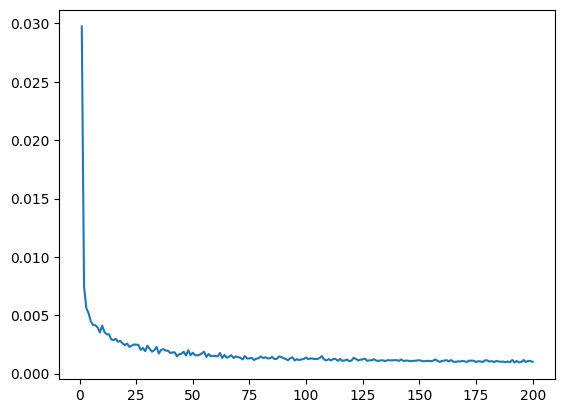

In [58]:
plt.plot(np.arange(1,201),history['loss'])
plt.plot(np.arange(1,201),history['loss'])

In [59]:
predicted = model.predict(test_X)
predicted = inv_norm(predicted,df['TOTAL_WAVE_HEIGHT'])

predicted.shape

32/32 [==============================] - 1s 6ms/step


(1000, 1)

In [60]:
len(test_data)

1000

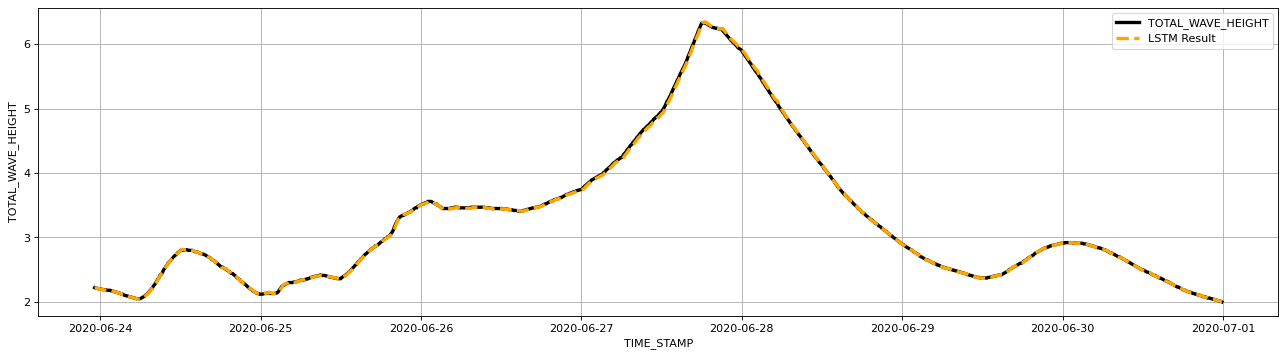

In [73]:
plt.figure(figsize=(20,5), dpi=80, facecolor='w', edgecolor='k')

sns.lineplot(x=test_data['TIME_STAMP'],y=test_data['TOTAL_WAVE_HEIGHT'],color='black',label='TOTAL_WAVE_HEIGHT',linewidth = 3)
sns.lineplot(x=test_data['TIME_STAMP'],y=predicted[:,0],color='orange',label='LSTM Result', linewidth = 3, linestyle='--')

plt.legend()
plt.grid(True)
plt.show()

In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# report performance
mse = mean_squared_error(test_data['TOTAL_WAVE_HEIGHT'], predicted)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data['TOTAL_WAVE_HEIGHT'], predicted)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data['TOTAL_WAVE_HEIGHT'], predicted))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predicted[:,0] - test_data['TOTAL_WAVE_HEIGHT'])/np.abs(test_data['TOTAL_WAVE_HEIGHT']))
print('MAPE: '+str(mape))
r2 = r2_score(test_data['TOTAL_WAVE_HEIGHT'], predicted)
print('R2: '+str(round(r2,3)))

MSE: 0.00020620792512964452
MAE: 0.009415745754241957
RMSE: 0.01435994168266865
MAPE: 0.0025517296558545907
R2: 1.0


# Save Model

In [63]:
import pickle

In [64]:
model.save('model_LSTM.h5')

In [65]:
def local_persist(fname, modelname) :
    fname = fname
    pickle.dump(modelname, open(fname, 'wb'))
local_persist('isolation_forest.pkl',iso)

In [66]:
df.to_csv("baseline_normalization.csv",index=False)

# Trial Deployment

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from numpy import hstack

import sqlalchemy
from sklearn.ensemble import IsolationForest

2022-11-22 12:52:51.562103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 12:52:51.747769: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-22 12:52:52.401366: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/extras/CUPTI/lib64
2022-11-22 12:52:52.401441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 

In [3]:
# ---- set database connection
database_username = 'root'
database_password = 'balab'
database_ip       = '172.17.0.7'
database_name     = 'data_hackathon'
database_connection = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                               format(database_username, database_password,
                                                      database_ip, database_name))

data = pd.read_sql('select * from data_source order by TIME_STAMP desc limit 60',con=database_connection)
data = data.sort_values("TIME_STAMP").reset_index(drop=True)
data['TIME_STAMP'] = pd.to_datetime(data['TIME_STAMP'])

baseline = pd.read_csv("baseline_normalization.csv")

ISO_MODEL  = "isolation_forest.pkl"
LSTM_MODEL = "model_LSTM.h5"

In [30]:
UPLIM  = baseline['TOTAL_WAVE_HEIGHT'].quantile(0.80)
LOWLIM = baseline['TOTAL_WAVE_HEIGHT'].quantile(0.20)
print(UPLIM,LOWLIM)

2.38 0.69


In [4]:
def preprocessing(df) :
    
    # FILTER FEATURES
    LIST_FEATURES = ['CURRENT_UV',
                     'CURRENT_SPEED',
                     'SPEED_VG',
                     'SPEED_LW',
                     'REL_WIND_SPEED',
                     'TOTAL_WAVE_HEIGHT',
                     'TOTAL_WAVE_DIRECTION',
                     'TOTAL_WAVE_PERIOD',
                     'WIND_UV',
                     'WIND_SPEED',
                     'PRESSURE_SURFACE',
                     'PRESSURE_MSL',
                     'SEA_SURFACE_SALINITY',
                     'ME1_RPM',
                     'ME1_FOC']
    
    df = df[['TIME_STAMP']+LIST_FEATURES]
    
    # ISOLATION FOREST
    trained_iso = open(ISO_MODEL,'rb')
    iso = pickle.load(trained_iso)
    iso_score = iso.score_samples(df.drop(['TIME_STAMP'],axis=1))
    iso_binary = iso.predict(df.drop(['TIME_STAMP'],axis=1))

    df['ISO_SCORE']  = iso_score
    df['ISO_BINARY'] = iso_binary

    # DAY or NIGHT
    df['DAY_NIGHT']  = df['TIME_STAMP'].apply(lambda x : 1 if 6<=pd.to_datetime(x).hour<=12 else 0)
    df['TIME_STAMP'] = pd.to_datetime(df['TIME_STAMP'])
    
    return df

In [5]:
inputs = preprocessing(data)

In [6]:
#normalization function
def norm(x,data):
    xn = (x - min(data)) / (max(data) - min(data))
    return xn
def inv_norm(xn,data) :
    x = (xn*(max(data) - min(data))) + min(data)
    return x

# define dataset
in_seq1 = np.array(norm(inputs['TOTAL_WAVE_HEIGHT'],baseline['TOTAL_WAVE_HEIGHT']))

in_seq2 = np.array(norm(inputs['CURRENT_UV'],baseline['CURRENT_UV']))
in_seq3 = np.array(norm(inputs['CURRENT_SPEED'],baseline['CURRENT_SPEED']))
in_seq4 = np.array(norm(inputs['SPEED_VG'],baseline['SPEED_VG']))
in_seq5 = np.array(norm(inputs['SPEED_LW'],baseline['SPEED_LW']))
in_seq6 = np.array(norm(inputs['REL_WIND_SPEED'],baseline['REL_WIND_SPEED']))
in_seq7 = np.array(norm(inputs['TOTAL_WAVE_DIRECTION'],baseline['TOTAL_WAVE_DIRECTION']))
in_seq8 = np.array(norm(inputs['TOTAL_WAVE_PERIOD'],baseline['TOTAL_WAVE_PERIOD']))
in_seq9 = np.array(norm(inputs['WIND_UV'],baseline['WIND_UV']))
in_seq10 = np.array(norm(inputs['WIND_SPEED'],baseline['WIND_SPEED']))
in_seq11 = np.array(norm(inputs['PRESSURE_SURFACE'],baseline['PRESSURE_SURFACE']))
in_seq12 = np.array(norm(inputs['PRESSURE_MSL'],baseline['PRESSURE_MSL']))
in_seq13 = np.array(norm(inputs['SEA_SURFACE_SALINITY'],baseline['SEA_SURFACE_SALINITY']))
in_seq14 = np.array(norm(inputs['ME1_RPM'],baseline['ME1_RPM']))
in_seq15 = np.array(norm(inputs['ME1_FOC'],baseline['ME1_FOC']))
in_seq16 = np.array(norm(inputs['ISO_SCORE'],baseline['ISO_SCORE']))
in_seq17 = np.array(norm(inputs['ISO_BINARY'],baseline['ISO_BINARY']))
in_seq18 = np.array(norm(inputs['DAY_NIGHT'],baseline['DAY_NIGHT']))

# reshape series
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))

in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))

in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))

in_seq16 = in_seq16.reshape((len(in_seq16), 1))
in_seq17 = in_seq17.reshape((len(in_seq17), 1))
in_seq18 = in_seq18.reshape((len(in_seq18), 1))

# horizontally stack columns
dataset_input = hstack((in_seq1,in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, in_seq17, in_seq18))
dataset_input = dataset_input.reshape(1,60,-1)

In [7]:
dataset_input.shape

(1, 60, 18)

In [8]:
trained_model = tf.keras.models.load_model(LSTM_MODEL)

2022-11-22 12:52:56.727285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 12:53:01.331143: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-22 12:53:01.331200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3690 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-11-22 12:53:01.332239: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variab

In [10]:
predicted = trained_model.predict(dataset_input)
predicted = inv_norm(predicted,baseline['TOTAL_WAVE_HEIGHT'])

2022-11-22 12:53:18.484763: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


1/1 [==============================] - 3s 3s/step


In [31]:
def condt(i):
    if i <= LOWLIM :
        return "LOW WAVE"
    elif i >= UPLIM :
        return "HIGH WAVE"
    else :
        return "MEDIUM WAVE"
    
result = pd.DataFrame({
    'FUTURE_TS' : [data.iloc[-1]['TIME_STAMP'] + pd.Timedelta(minutes=10)],
    'TOTAL_WAVE_HEIGHT' : predicted[0],
    'LABELS' : [condt(i) for i in  predicted]
})

# ---- proses ingestion to databases
result.to_sql(con=database_connection, name='dm_lstm_prediction', if_exists='replace',index=False)

1

In [32]:
result

,FUTURE_TS,TOTAL_WAVE_HEIGHT,LABELS
0,2020-07-01 00:00:00+00:00,1.991343,MEDIUM WAVE


# Graph

In [33]:
# html.Div([
#         daq.LEDDisplay(
#             id='LED-display-WAVEHEIGHT',
#             label='longitude',
#             value=00,
#             size=30,
#             color='#10A5F5'
#         ),
#     ],style={'textAlign': 'right','verticalAlign': 'middle'})

In [34]:
print(LOWLIM, UPLIM)


0.69 2.38


In [ ]:
html.Div([
        daq.Gauge(
            id='level-gauge',
            color={
                "gradient": True,
                "ranges": {"green": [0., 0.69],"yellow": [0.69, 2.38] ,"red": [0.55, 10]},
            },
            label="anomaly score",
            style={'stroke-width': '20px'},
            size=250,
            max=0.8,
            min=0,
            value=0.3
        )
    ])